In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from general_utils import timer

from config import RANDOM_SEED

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from bert_embeddings import get_tokens_from_bert_tokenizer

from collections import Counter, defaultdict

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegressionCV
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import pickle
import random

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [4]:
import torch
import pickle
from transformers import BertModel, BertTokenizer
from general_utils import timer
import os
import numpy as np
from bert_utils import load_model, load_tokenizer, batch_text_gen
import torch
from collections import defaultdict
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
torch.cuda.device_count()

2

In [6]:
torch.cuda.set_device(0)

In [7]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = False

In [36]:
def get_kw_bert_rep(kw_list,layer_map,bert_tokenizer,bert_model,bs=10):
    """
    """
    batch_count = 0
    for kw_batch in batch_text_gen(kw_list,batch_size = bs):
        print("Batch No : %s" %str(batch_count))
        tokenized_kw_batch, encoded_batch_ids = tokenize_bert_single_token(kw_batch,bert_tokenizer)
        batch_out = bert_model(input_ids=tokenized_kw_batch)
        batch_hidden_states = batch_out[2] # 13 layers as layer(0) is input to the transformer 
        
        for layer_ind in range(13):
            for t_id, token in enumerate(kw_batch):
                token_hidden_state = batch_hidden_states[layer_ind][t_id,:,:].cpu().detach().numpy()
                # index here to drop the pad tokens and only consider the actual word representation (if subwords then avg the subwords to get word representation) (PAD has token id of 0)
                token_hidden_state = combine_subwords(token_hidden_state,encoded_batch_ids[t_id])
                layer_map[token]["layer_%s"%str(layer_ind)] = token_hidden_state
        batch_count+=1 
        
def tokenize_bert_single_token(token_batch,tokenizer,debug_flag=False):
    """
    """
    encoded_batch = []
    for token in token_batch:
        encoded_token = tokenizer.encode(token,add_special_tokens=False,padding="max_length",max_length=10) # padding is longest because subwords exist in the vocab so the tokenizer splits a given word into subwords
        if debug_flag:
            print(token)
            print(tokenizer.convert_ids_to_tokens(encoded_token))
        encoded_batch.append(encoded_token)
    
    tokenized_batch = torch.LongTensor(encoded_batch)
    tokenized_tensor = tokenized_batch.to('cuda')
    return tokenized_tensor, encoded_batch

def compare_bert_rep_token(kw_topic_specific,kw_topic_indep,plot=True):
    """
    """
    bert_mod = load_model()
    bert_tok = load_tokenizer()
    
    bert_map = defaultdict(lambda :defaultdict())
    
    # topic specific keywords
    print("Getting bert representation for Topic Specific Keywords ... \n")
    batch_size = get_batch_size(kw_topic_specific)
    
    get_kw_bert_rep(kw_list=kw_topic_specific,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # topic indep keywords
    print("Getting bert representation for Topic Independent Keywords ... \n")
    batch_size = get_batch_size(kw_topic_indep)
    
    get_kw_bert_rep(kw_list=kw_topic_indep,
                    layer_map=bert_map,
                    bert_tokenizer=bert_tok,
                    bert_model=bert_mod,
                    bs=batch_size)
    
    # cosin_sim
    cosine_sims_layer_map = defaultdict(list)
    pair_count=0
    for wp in itertools.product(kw_topic_indep,kw_topic_specific):
        for layer_id in range(13):
            cos_sim = cosine_similarity(bert_map[wp[0]]["layer_%s"%str(layer_id)],bert_map[wp[1]]["layer_%s"%str(layer_id)])
            cosine_sims_layer_map[layer_id].append(cos_sim)
        pair_count+=1
    
    print("No of Pairs : %s" %str(pair_count))
    
    # avg
    avg_scores = []
    for layer in sorted(cosine_sims_layer_map.keys()):
        avg_scores.append(np.mean(cosine_sims_layer_map[layer]))
    
    # plot
    if plot:
        fig,ax = plt.subplots(1,1,figsize=(10,8))
        ax.scatter(range(13),avg_scores,s=100)
        ax.set_xlabel("Bert Layers")
        ax.set_ylabel("Avg Cosine Similarity")
        ax.set_xticks(range(-1,13,1))
        ax.set_xlim(-1,13)
        ax.set_ylim(0.0,1.0)
        sns.regplot(x=[i for i in range(13)], y=avg_scores,ax=ax,color="cornflowerblue")
        plt.title("Average Cosine Similarity between Topic Independant Keywords and Topic Specific Keywords\n for Representations from different Layers of BERT")
        plt.grid(True, linestyle='--')
        plt.tight_layout()
        plt.show()
    return bert_map,avg_scores
        
def get_batch_size(kw_list,ratio=10):
    """
    """
    batch_size = int(len(kw_list)/ratio)
    
    if len(kw_list) <=25:
        batch_size = len(kw_list)
    
    return batch_size

def combine_subwords(hidden_state,token_ids):
    """
    hidden_state_shape = (maxlength_padding,768)
    
    choose token_ids that are not 0
    
    """
    subword_arrs = []
    for t_i,t in enumerate(token_ids):
        if t != 0:
            subword_arrs.append(hidden_state[t_i,:])
    
    return np.mean(subword_arrs,axis=0).reshape(1,-1)

@timer
def get_all_clustered_docs(keywords,clusters,doc_2_cluster_map,sample_df,partisan_score=0):
    """
    """
    relv_docs_cluster_map = defaultdict(lambda : defaultdict(list))
    keyword_index_cluster_map = defaultdict(lambda : defaultdict(list))
    total_docs_per_cluser = defaultdict(lambda : defaultdict(int))
    tokenizer = load_tokenizer()
    for c in clusters:
        print("\nCluster : %s" %str(c))
        docs_indexes = doc_2_cluster_map[c]
        texts = sample_df["all_text"].iloc[docs_indexes].tolist()
        partisan_scores = sample_df["binary_ps"].iloc[docs_indexes].tolist()
        for k in keywords:
            print("Keyword : %s" %str(k))
            for ind_t,t in enumerate(texts):
                if k in t.lower() and partisan_scores[ind_t]==partisan_score:
                    for ind,w in enumerate(get_tokens_from_bert_tokenizer(t.lower(),tokenizer)):
                        if  w == k or k in w:
                            if ind < 500:
                                keyword_index_cluster_map[k][c].append(ind)
                                relv_docs_cluster_map[k][c].append(t)
        
            total_docs_per_cluser[k][c] = len(relv_docs_cluster_map[k][c])
    
    print(total_docs_per_cluser)
    
    return relv_docs_cluster_map, keyword_index_cluster_map
        
def batch_text_gen_ind(text_list,index_list,batch_size=2):
    """
    """
    for ndx in range(0,len(text_list),batch_size):
        yield (text_list[ndx:min(ndx+batch_size,len(text_list))], index_list[ndx:min(ndx+batch_size,len(text_list))])

def tokenize_for_bert(text_batch,tokenizer):
    """
    """
    tokenized_tensor = torch.LongTensor([tokenizer.encode(text,
                                                          truncation=True,
                                                          padding="max_length",
                                                          max_length=500, 
                                                          add_special_tokens=False)  # Add [CLS] and [SEP],) 
                                                          for text in text_batch])
    tokenized_tensor = tokenized_tensor.to('cuda')
    return tokenized_tensor


@timer
def get_embeddings(keywords,relv_docs_cluster_map,keyword_index_cluster_map):
    """
    here i am only considering the last occurence of a keyword in a given document
    """
    bert_tokenizer = load_tokenizer()
    bert_model = load_model()
    layer_keyword_cluster_map = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
    
    for keyword in keywords:
        print("\nKeyword : %s" %keyword)
        for cluster in relv_docs_cluster_map[keyword].keys():
            print("Cluster : %s" %str(cluster))
            cluster_docs = relv_docs_cluster_map[keyword][cluster]
            if len(cluster_docs) > 0:
                keyword_indices = keyword_index_cluster_map[keyword][cluster]
                for cluster_doc_batch, keyword_indices_batch in batch_text_gen_ind(cluster_docs,keyword_indices,batch_size=2):
                    try:
                        tokenized_batch_text = tokenize_for_bert(text_batch=cluster_doc_batch,tokenizer=bert_tokenizer)
                        batch_out = bert_model(input_ids=tokenized_batch_text)
                        batch_hidden_states = batch_out[2] # 13 layers as layer(0) is input to the transformer 

                        for layer in range(13):
                            temp_reps = []
                            for ind,k_ind in enumerate(keyword_indices_batch):
                                temp_reps.append(batch_hidden_states[layer][ind,k_ind,:].cpu().detach().numpy())
                            layer_keyword_cluster_map[keyword][cluster][layer]+=temp_reps
                
                    except Exception as e:
                        print("Error Raised : \n")
                        print(e)
                    

    return layer_keyword_cluster_map


def take_mean(layer_keyword_cluster_map):
    """
    """
    for keyword in layer_keyword_cluster_map.keys():
        for cluster in layer_keyword_cluster_map[keyword].keys():
            for layer in layer_keyword_cluster_map[keyword][cluster].keys():
                list_batch_outs = layer_keyword_cluster_map[keyword][cluster][layer]
                layer_keyword_cluster_map[keyword][cluster][layer] = np.mean(list_batch_outs,axis=0).reshape(1,-1)

def plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword,avg_rp_word_sim):
    """
    """
    clusters = layer_keyword_cluster_map[keyword].keys()
    
    cluster_pairs = list(itertools.combinations(clusters,2))
    fig,ax = plt.subplots(1,1,figsize=(30,12))
    colors_map = sns.color_palette("tab20", n_colors=13)
    
    cosine_sims_map ={}
    
    for layer in range(1,13,1):
        
        cosine_sims = []
        x = [i for i in range(len(cluster_pairs))]
        for cp in cluster_pairs:
            cosine_sim = cosine_similarity(layer_keyword_cluster_map[keyword][cp[0]][layer],layer_keyword_cluster_map[keyword][cp[1]][layer])
            temp = (cosine_sim/avg_rp_word_sim[layer])[0]
            cosine_sims.append(temp)
        
        temp_cos = np.concatenate(cosine_sims,axis=0)
        indices = np.argsort(temp_cos)
        cosine_sims_map[layer]=[cluster_pairs[i] for i in indices]
        
        
        ax.scatter(x,cosine_sims,color=colors_map[layer],s=50,label="layer_%s"%str(layer))
#         sns.regplot(x=x, y=cosine_sims,ax=ax,color=colors_map[layer])
    
    ax.set_xlabel("Cluster-Pairs")
    ax.set_ylabel("Cosine Similarity")
#     ax.set_ylim(0.0,1.0)
#     ax.set_xticks([i for i in range(len(cluster_pairs))])
#     ax.set_xticklabels([ str(cp) for cp in cluster_pairs],rotation = 90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Average Cosine Similarity between Bert Representations of **** %s **** for each layer"%str(keyword))
    plt.grid(False, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # get the lowest scoring cluster pairs
    return cosine_sims_map

def analyze_cluster_pairs(cps,relv_docs_cluster_map,keyword):
    """
    """
    tokenizer = load_tokenizer()
    for cp in cps:
        print("\n********* Analyzing Cluster Pair : %s************\n" %str(cp))
        cluster_docs_with_keyword_1 = relv_docs_cluster_map[keyword][cp[0]]
        cluster_docs_with_keyword_2 = relv_docs_cluster_map[keyword][cp[1]]
        
        print("Cluster %s has %s docs that contain %s keyword"%(str(cp[0]),len(cluster_docs_with_keyword_1),keyword))
        print("Cluster %s has %s docs that contain %s keyword"%(str(cp[1]),len(cluster_docs_with_keyword_2),keyword))
        
        print("\nRandom Docs from Cluster : %s"%str(cp[0]))
        sample_size = 5 
        if len(cluster_docs_with_keyword_1) <= sample_size:
            sample_size = len(cluster_docs_with_keyword_1)
        sample_cdwk1 = random.sample(cluster_docs_with_keyword_1,sample_size)
        for doc in sample_cdwk1:
            print("\n")
            print(doc)
            tokens,tok_inds = get_tokens_from_bert_tokenizer(doc,tokenizer)
            occurences = 0
            for tok_index,tok in enumerate(tokens):
                if tok == keyword:
                    print("\n5 Words Before %s :"%str(keyword))
                    print(tokens[tok_index-6:tok_index])
                    print("\n5 Words After %s :"%str(keyword))
                    print(tokens[tok_index:tok_index+6])
                    occurences +=1
            
            print("\n%s occurred %s times in the above document"%(keyword,str(occurences)))
        
        print("\nRandom Docs from Cluster : %s"%str(cp[1]))
        sample_size = 5 
        if len(cluster_docs_with_keyword_2) <= sample_size:
            sample_size = len(cluster_docs_with_keyword_2)
        sample_cdwk1 = random.sample(cluster_docs_with_keyword_2,sample_size)
        for doc in sample_cdwk1:
            print("\n")
            print(doc)
            tokens,tok_inds = get_tokens_from_bert_tokenizer(doc,tokenizer)
            occurences = 0
            for tok_index,tok in enumerate(tokens):
                if tok == keyword:
                    print("\n5 Words Before %s :"%str(keyword))
                    print(tokens[tok_index-5:tok_index+1])
                    print("\n5 Words After %s :"%str(keyword))
                    print(tokens[tok_index-1:tok_index+5])
                    occurences +=1
            
            print("\n%s occurred %s times in the above document"%(keyword,str(occurences)))
        

def plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword,avg_rp_word_sim):
    """
    """
    clusters = layer_keyword_cluster_map[keyword].keys()
    
    cluster_pairs = list(itertools.combinations(clusters,2))
    fig,ax = plt.subplots(1,1,figsize=(10,8))
    colors_map = sns.color_palette("tab20", n_colors=13)
    
    for layer in range(1,13,1):
        
        cosine_sims = []
        x = [i for i in range(len(cluster_pairs))]
        for cp in cluster_pairs:
            cosine_sim = cosine_similarity(layer_keyword_cluster_map[keyword][cp[0]][layer],layer_keyword_cluster_map[keyword][cp[1]][layer])
            cosine_sims.append(cosine_sim/avg_rp_word_sim[layer])
    
        avg_cosine_sim = np.mean(cosine_sims)
        
        ax.scatter(layer,avg_cosine_sim,color=colors_map[layer],s=100,label="layer_%s"%str(layer))
    
    ax.set_xlabel("Bert Layer Representations")
    ax.set_ylabel("Average Cosine Similarity of a Keyword Across all Cluster Pairs")
#     ax.set_ylim(0.0,1.0)
    plt.legend()
    plt.title("Average Cosine Similarity of a Keyword Across all Cluster Pairs vs Bert Representations across all layers")
    plt.grid(False, linestyle='--')
    plt.tight_layout()
    plt.show()
    

def plot_all_keywords_avg_cos_sim_all_layers(layer_keyword_cluster_map):
    """
    """
    
    for keyword in layer_keyword_cluster_map.keys():
        
        clusters = layer_keyword_cluster_map[keyword].keys()
    
        cluster_pairs = list(itertools.combinations(clusters,2))
        
        

In [9]:
def load_pkl_file(file_path):
    """
    """
    article_dict = pickle.load(open(file_path,"rb"))
    articles = []
    for article in article_dict.keys():
        articles.append(article_dict[article])
    
    print("Number of Articles : %s"%str(len(articles)))
    articles_df = pd.DataFrame(articles)
    print("Shape Before Processing : %s" %str(articles_df.shape))
    #drop columns
    articles_df.drop(columns=["article_id",
                              "url",
                              "source",
                              "tweet_id",
                              "tweet_text",
                              "kws_label",
                              "cls_label",
                              "tweet_screen_name",
                              "tweet_created_at"],inplace=True)
    #reset index
    articles_df.reset_index(inplace=True,drop=True)
    #drop partisan of 0.0
    articles_df = articles_df.loc[articles_df["source_partisan_score"] != 0.0]
    articles_df["binary_ps"] = articles_df["source_partisan_score"].apply(lambda x: 1 if x>0 else 0)
    print("Shape after dropping Neutral Articles : %s" %str(articles_df.shape))
    print(articles_df.columns)
    return articles_df

In [10]:
path =  "../labeled_political_articles.pkl"

articles_df = load_pkl_file(path)

sampled_df = sample_data(df=articles_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

Number of Articles : 219824
Shape Before Processing : (219824, 12)
Shape after dropping Neutral Articles : (170405, 4)
Index(['title', 'text', 'source_partisan_score', 'binary_ps'], dtype='object')

Finished running 'sample_data' in 0.0007 mins

Sampled Size: 100000


In [11]:
sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])
vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=sampled_df,min_df=50,max_df=0.75,seed=RANDOM_SEED)
# reduced_vectors = dimensionality_reduction(vectors=vectors,mode="SVD_LSA",dim=500,seed=RANDOM_SEED)
reduced_vectors = vectors
clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=100,clus_type="kmeans")
cluster_sizes = get_cluster_sizes(cluster_clf)
cluster_pairs = get_cluster_pairs(num_clusters=100)
print(len(cluster_pairs))

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3431 mins

vocab_size : 8000

Finished running 'tfidf_vectorization' in 0.1907 mins


Running KMEANS Clustering with k=100

Finished running 'run_clustering' in 0.0650 mins


Finished running 'get_cluster_sizes' in 0.0002 mins


Number of Cluster Pairs : 4950

Finished running 'get_cluster_pairs' in 0.0000 mins

4950


In [12]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0003 mins



In [13]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=200,
                                        max_size=10000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.0162 mins

Filtered CLustered Pairs : 990


In [14]:
clusters = []
for cp in filtered_cluster_pairs:
    clusters.append(cp[0])
    clusters.append(cp[1])

print(set(clusters))
print(len(set(clusters)))
clusters = list(set(clusters))

{0, 2, 8, 11, 12, 14, 15, 16, 21, 22, 24, 27, 28, 31, 35, 36, 40, 43, 44, 46, 50, 52, 53, 57, 58, 59, 60, 64, 66, 68, 69, 71, 76, 77, 78, 80, 82, 85, 86, 90, 92, 93, 94, 96, 99}
45


In [15]:
print(len(doc_2_cluster_map[28]))

486


In [16]:
# Keywords Professor Identified:
conservative_keywords = ["democrats", "media","socialist"]
liberal_keywords = ["donald", "republicans", "progressive"]

# overlapping_conservative_keywords:
#     pick top 50 from file
    
# overlapping_liberal_keywords:
#     pick top 50 from file

In [17]:
from urllib.request import Request, urlopen
import random


url="https://svnweb.freebsd.org/csrg/share/dict/words?revision=61569&view=co"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

web_byte = urlopen(req).read()

webpage = web_byte.decode('utf-8')
words = webpage.split("\n")
print(len(words))

25488


In [18]:
rl1 = [random.choice(words).strip() for i in range(100)]
rl2 = [random.choice(words).strip() for i in range(100)]

In [19]:
# have to computer pair wise cosine similarity between 2 of these lists, avg them then divide the rest in take_mean
layer_map,avg_scores_rp = compare_bert_rep_token(kw_topic_specific=rl1,
                                   kw_topic_indep=rl2,plot=False)

Getting bert representation for Topic Specific Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
Getting bert representation for Topic Independent Keywords ... 

Batch No : 0
Batch No : 1
Batch No : 2
Batch No : 3
Batch No : 4
Batch No : 5
Batch No : 6
Batch No : 7
Batch No : 8
Batch No : 9
No of Pairs : 10000


In [20]:
avg_rp_score = np.array(avg_scores_rp)

In [21]:
avg_rp_score.shape

(13,)

In [22]:
# To-DO:
# * for each keyword , get the cluster-stance documents that contain it, repeat for each cluster
# * you will get a dict of cluster-docs for each keyword
# * from this get bert embeddings for each cluster by averaging the corresponding word embedding for the keyword
# * for every cluster pair:
#     * calculate cosine sim between the averaged vectors
#     * repeat for each bert layer
# * create a map from layer -> list of cosine similarities between the cluster pairs
# * plot for each layer
# * plot avg cosine sim vs layer for each keyword
# * plot avg cosine sim for all conservative keywords vs layer
# * plot avg cosine sim for all liberal keywords vs layer

## Conservative Keywords Results :

In [23]:
relv_docs_cluster_map, keyword_index_cluster_map = get_all_clustered_docs(keywords=conservative_keywords,
                                                                          clusters=clusters,
                                                                          doc_2_cluster_map=doc_2_cluster_map,
                                                                          sample_df=sampled_df, partisan_score=1)


Cluster : 0
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 2
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 8
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 11
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 12
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 14
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 15
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 16
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 21
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 22
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 24
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 27
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 28
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 31
Keyword : democrats
Keyword : media
Keyword : socialist

Cluster : 35
Keyword :

In [24]:
relv_docs_cluster_map["democrats"][28]

["Pollak: Trump's Canceled Taliban Meeting Improves America's Global Leverage president donald trump receiving mixed reviews for scheduling then canceling secret meeting with taliban representatives that was have taken place camp david last weekend democrats blasted trump for treating diplomacy like “game show” while republicans were both aghast the meeting and relieved that had nixed more important the meeting and cancelation improve america’ leverage both afghanistan and elsewhere trump like president barack obama before him looking for way bring forces home obama foolishly set timeline for his troop “surge” making clear that political considerations were more important him than victory and traded five senior taliban leaders for deserter bowe bergdahl swap that damaged america’ bargaining position well military morale since taking office trump has been looking for dignified exit was not clear things were headed that direction medianame news national security editor frances martel has

In [25]:
layer_keyword_cluster_map = get_embeddings(keywords=conservative_keywords,
                                           relv_docs_cluster_map=relv_docs_cluster_map,
                                           keyword_index_cluster_map=keyword_index_cluster_map)


Keyword : democrats
Cluster : 0
Cluster : 2
Cluster : 8
Cluster : 11
Cluster : 12
Cluster : 14
Cluster : 15
Cluster : 16
Cluster : 21
Cluster : 22
Cluster : 24
Cluster : 27
Cluster : 28
Cluster : 31
Cluster : 35
Cluster : 36
Cluster : 40
Cluster : 43
Cluster : 44
Cluster : 46
Cluster : 50
Cluster : 52
Cluster : 53
Cluster : 57
Cluster : 58
Cluster : 59
Cluster : 60
Cluster : 64
Cluster : 66
Cluster : 68
Cluster : 69
Cluster : 71
Cluster : 76
Cluster : 77
Cluster : 78
Cluster : 80
Cluster : 82
Cluster : 85
Cluster : 86
Cluster : 90
Cluster : 92
Cluster : 93
Cluster : 94
Cluster : 96
Cluster : 99

Keyword : media
Cluster : 0
Cluster : 2
Cluster : 8
Cluster : 11
Cluster : 12
Cluster : 14
Cluster : 15
Cluster : 16
Cluster : 21
Cluster : 22
Cluster : 24
Cluster : 27
Cluster : 28
Cluster : 31
Cluster : 35
Cluster : 36
Cluster : 40
Cluster : 43
Cluster : 44
Cluster : 46
Cluster : 50
Cluster : 52
Cluster : 53
Cluster : 57
Cluster : 58
Cluster : 59
Cluster : 60
Cluster : 64
Cluster : 66
Cluste

In [26]:
take_mean(layer_keyword_cluster_map)

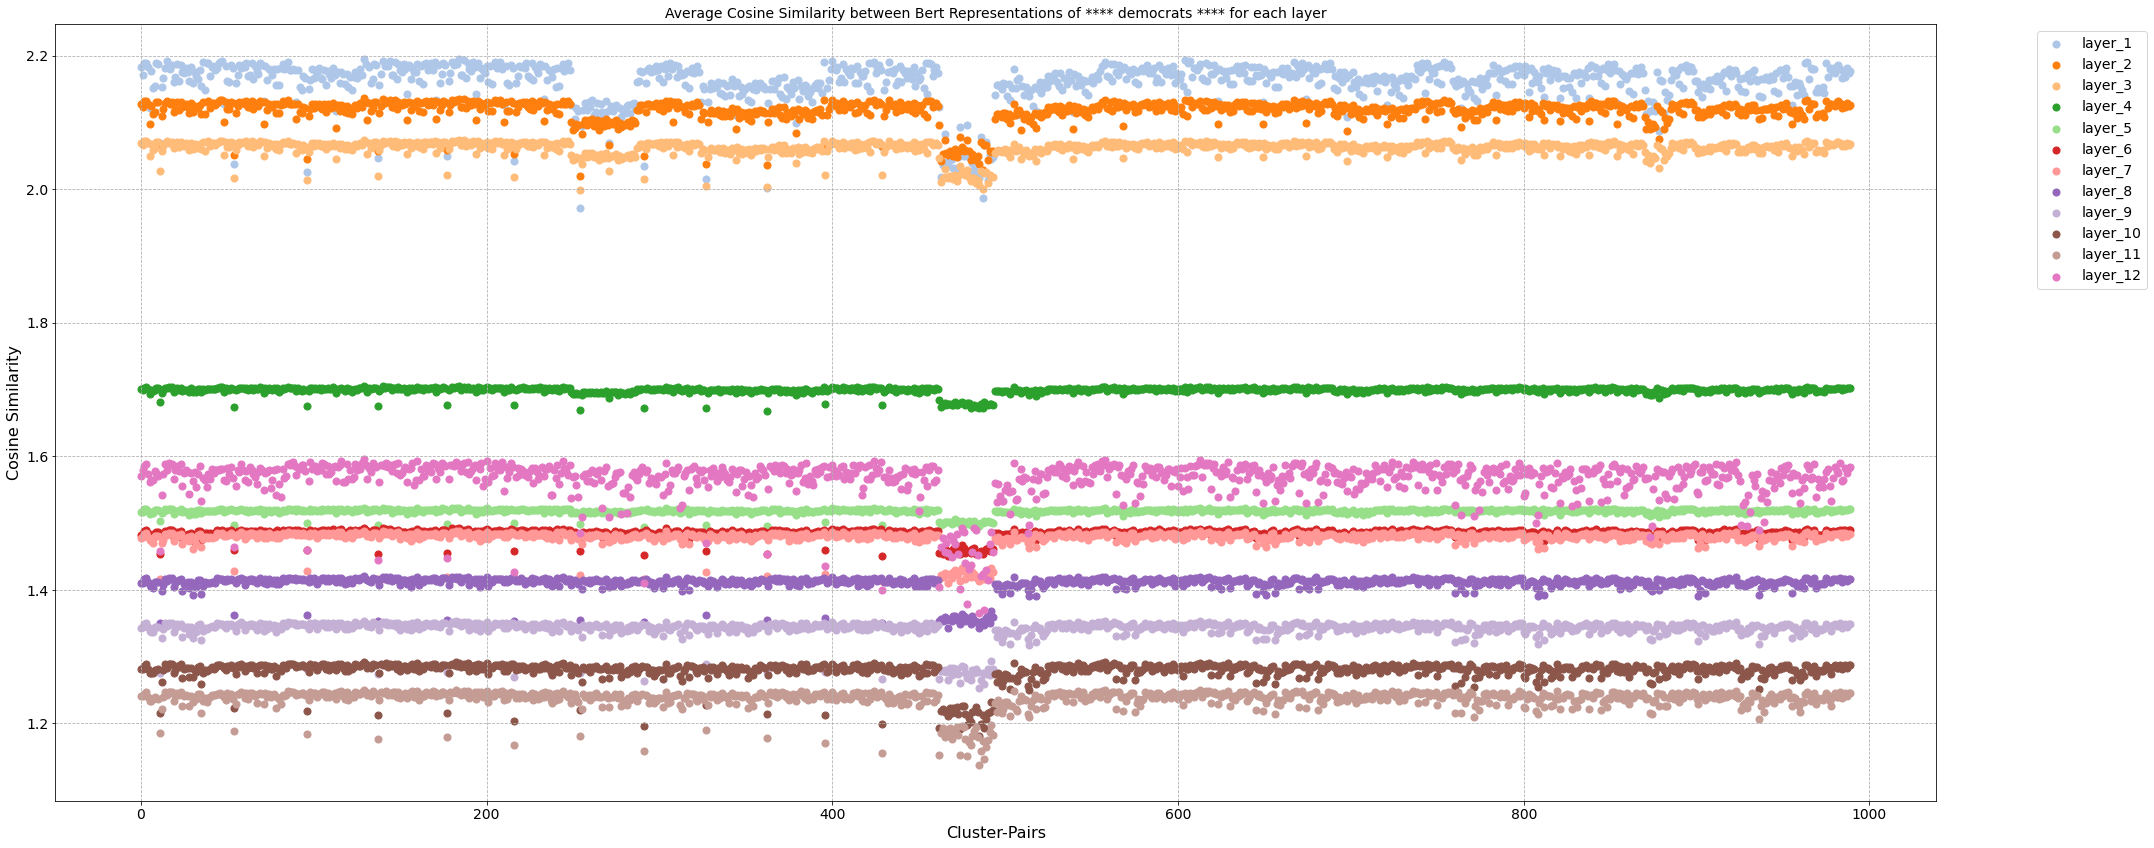

In [37]:
cosine_sim_map_scores = plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="democrats",avg_rp_word_sim=avg_rp_score)

In [38]:
analyze_cluster_pairs(cps=cosine_sim_map_scores[12][:5],
                      relv_docs_cluster_map=relv_docs_cluster_map,
                      keyword="democrats")


********* Analyzing Cluster Pair : (28, 82)************

Cluster 28 has 2 docs that contain democrats keyword
Cluster 82 has 11 docs that contain democrats keyword

Random Docs from Cluster : 28


Trump envoy keeps door open to new Afghanistan peace talks president trump has declared peace talks with taliban militants afghanistan america’ longest war were “dead” earlier this month but his top negotiator and senior state department official thursday hinted there chance they can revived veteran diplomat zalmay khalilzad who led nearly year talks with the taliban peace settlement gave classified briefing members the house foreign relations committee thursday leaving least one lawmaker believing there was room for more diplomacy “ personal opinion that they will resume” rep ted yoho florida republican said interview after the classified briefing with khalilzad the session was believed khalilzad’ first extensive description lawmakers the course the taliban talks the deal “ principle” annou

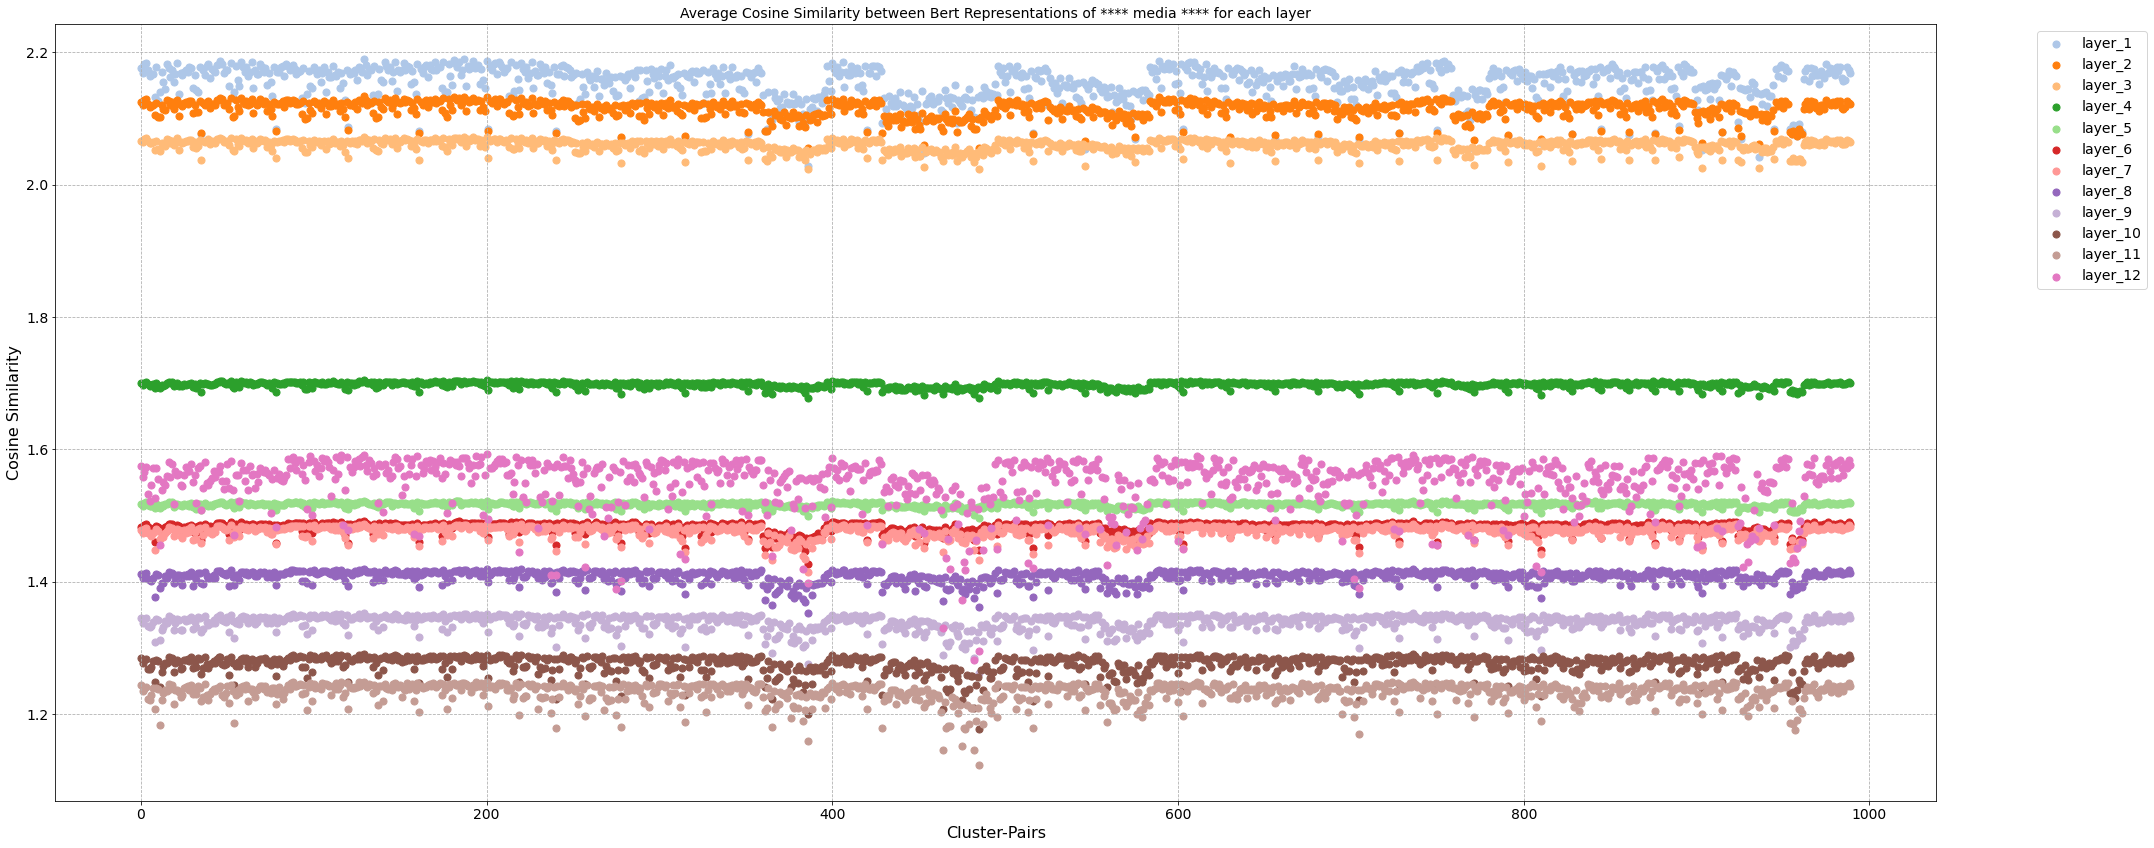

In [39]:
cosine_sim_map_scores = plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="media",avg_rp_word_sim=avg_rp_score)

In [40]:
analyze_cluster_pairs(cps=cosine_sim_map_scores[12][:5],
                      relv_docs_cluster_map=relv_docs_cluster_map,
                      keyword="media")


********* Analyzing Cluster Pair : (28, 77)************

Cluster 28 has 11 docs that contain media keyword
Cluster 77 has 11 docs that contain media keyword

Random Docs from Cluster : 28


Taliban say ready for talks with Kabul after Eid holiday islamabad the taliban say they are ready for talks with afghanistans political leadership after the muslim holiday eid adha the end july offering hand over the last the government prisoners weeks time providing the government frees the last its taliban prisoners the offer made taliban´ political spokesman suhail shaheen tweet late thursday follows one the most significant shakeups the taliban years the group appointed the son the movement´ fearsome founder head its military wing and powerful leadership council members its negotiation team kabul friday the high council for national reconciliation which was created may manage peace efforts with the taliban said was still working through the talibans prisoner list javed faisal spokesman for the 

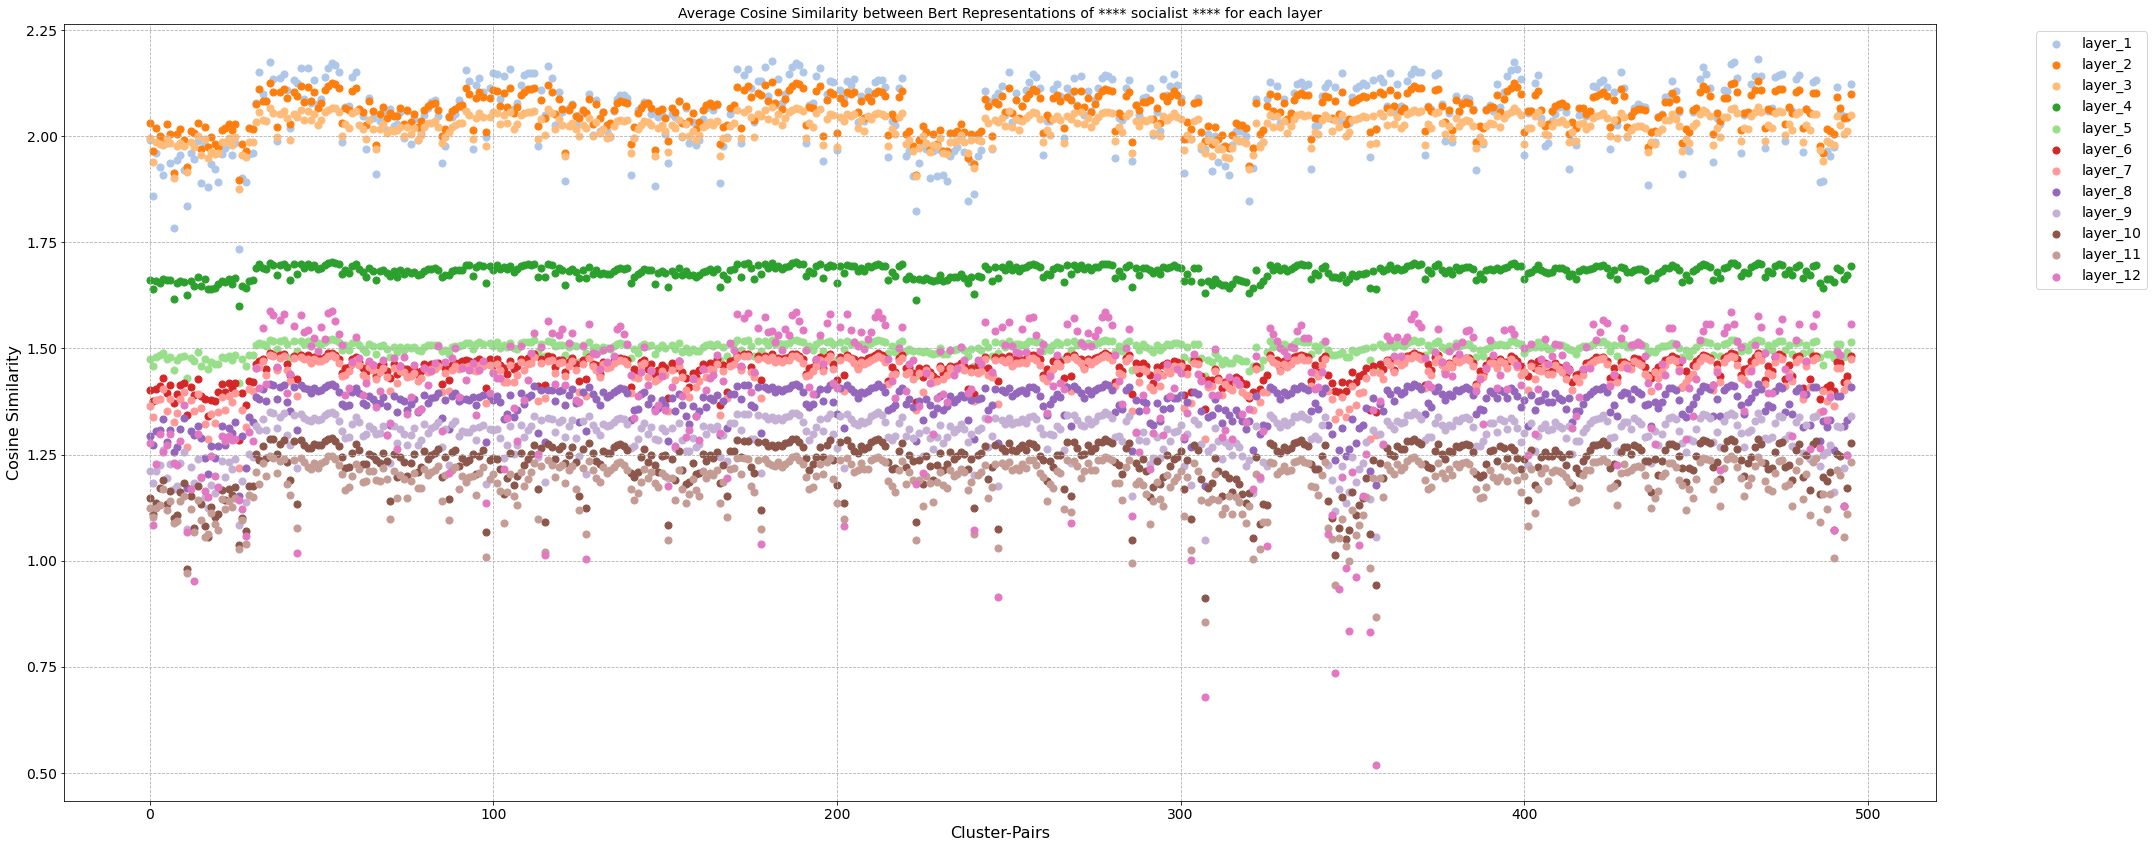

In [41]:
cosine_sim_map_scores = plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="socialist", avg_rp_word_sim=avg_rp_score)

In [42]:
analyze_cluster_pairs(cps=cosine_sim_map_scores[12][:5],
                      relv_docs_cluster_map=relv_docs_cluster_map,
                      keyword="socialist")


********* Analyzing Cluster Pair : (53, 94)************

Cluster 53 has 5 docs that contain socialist keyword
Cluster 94 has 2 docs that contain socialist keyword

Random Docs from Cluster : 53


Democrats, Media Attack Trump For Killing Terrorists Responsible For Killing U.S. Soldiers democrats and journalists attacked president donald trump thursday for killing notorious terrorist who was responsible for murdering hundreds american soldiers iraq “ forces killed qassem soleimani leader iran’ islamic revolutionary guard corps’ irgc qod’ force — which designated terrorist organization — airstrike baghdad was traveling baghdad international airport” the medianame reported “also killed the strike was top iraqi paramilitary commander abu mahdi almohandes who headed the iranianlinked popular mobilization forces” fox news reporter lucas tomlinson noted that government statistics indicate that iran was responsible for killing least 608 troops during iraq war and that soleimani led all irania

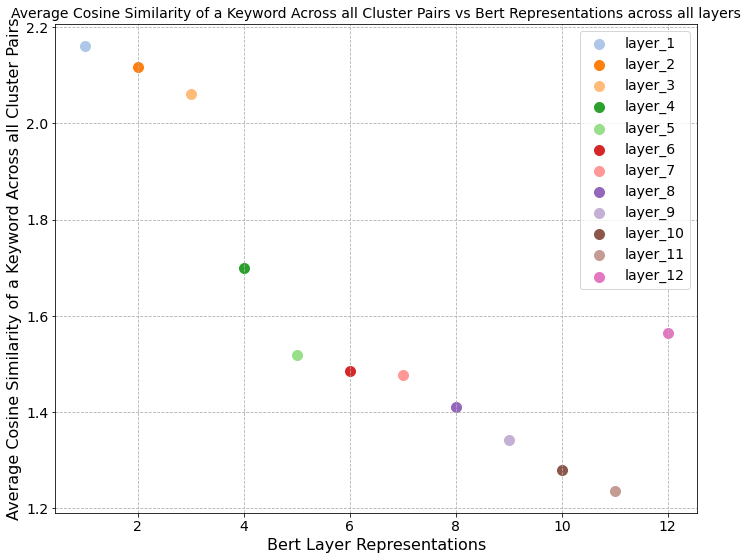

In [43]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="democrats",avg_rp_word_sim=avg_rp_score)

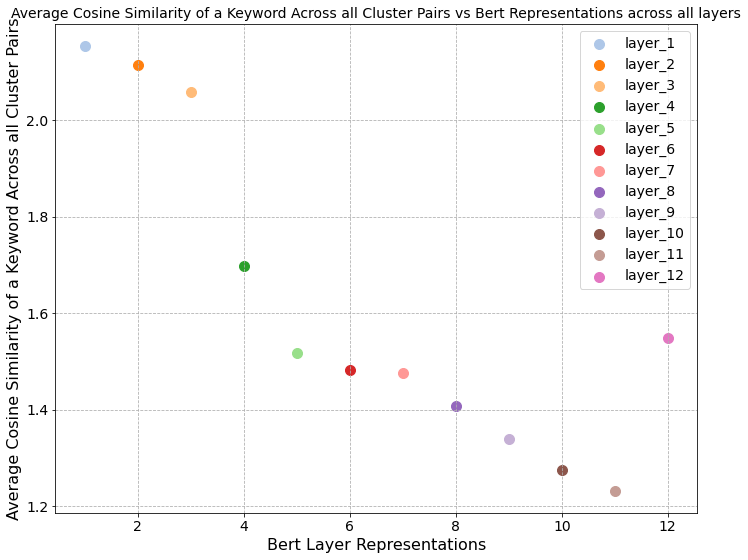

In [44]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="media",avg_rp_word_sim=avg_rp_score)

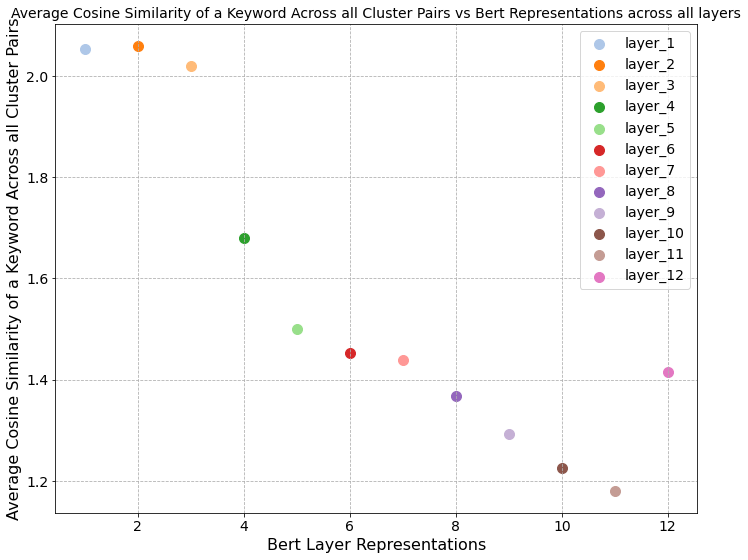

In [45]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="socialist",avg_rp_word_sim=avg_rp_score)

## Liberal Keyword Results :

In [47]:
relv_docs_cluster_map, keyword_index_cluster_map = get_all_clustered_docs(keywords=liberal_keywords,
                                                                          clusters=clusters,
                                                                          doc_2_cluster_map=doc_2_cluster_map,
                                                                          sample_df=sampled_df, partisan_score=0)


Cluster : 0
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 2
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 8
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 11
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 12
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 14
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 15
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 16
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 21
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 22
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 24
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 27
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 28
Keyword : donald
Keyword : republicans
Keyword : progressive

Cluster : 31
Keyword : dona

In [48]:
layer_keyword_cluster_map = get_embeddings(keywords=liberal_keywords,
                                           relv_docs_cluster_map=relv_docs_cluster_map,
                                           keyword_index_cluster_map=keyword_index_cluster_map)


Keyword : donald
Cluster : 0
Cluster : 2
Cluster : 8
Cluster : 11
Cluster : 12
Cluster : 14
Cluster : 15
Cluster : 16
Cluster : 21
Cluster : 22
Cluster : 24
Cluster : 27
Cluster : 28
Cluster : 31
Cluster : 35
Cluster : 36
Cluster : 40
Cluster : 43
Cluster : 44
Cluster : 46
Cluster : 50
Cluster : 52
Cluster : 53
Cluster : 57
Cluster : 58
Cluster : 59
Cluster : 60
Cluster : 64
Cluster : 66
Cluster : 68
Cluster : 69
Cluster : 71
Cluster : 76
Cluster : 77
Cluster : 78
Cluster : 80
Cluster : 82
Cluster : 85
Cluster : 86
Cluster : 90
Cluster : 92
Cluster : 93
Cluster : 94
Cluster : 96
Cluster : 99

Keyword : republicans
Cluster : 0
Cluster : 2
Cluster : 8
Cluster : 11
Cluster : 12
Cluster : 14
Cluster : 15
Cluster : 16
Cluster : 21
Cluster : 22
Cluster : 24
Cluster : 27
Cluster : 28
Cluster : 31
Cluster : 35
Cluster : 36
Cluster : 40
Cluster : 43
Cluster : 44
Cluster : 46
Cluster : 50
Cluster : 52
Cluster : 53
Cluster : 57
Cluster : 58
Cluster : 59
Cluster : 60
Cluster : 64
Cluster : 66
Clu

In [49]:
take_mean(layer_keyword_cluster_map)

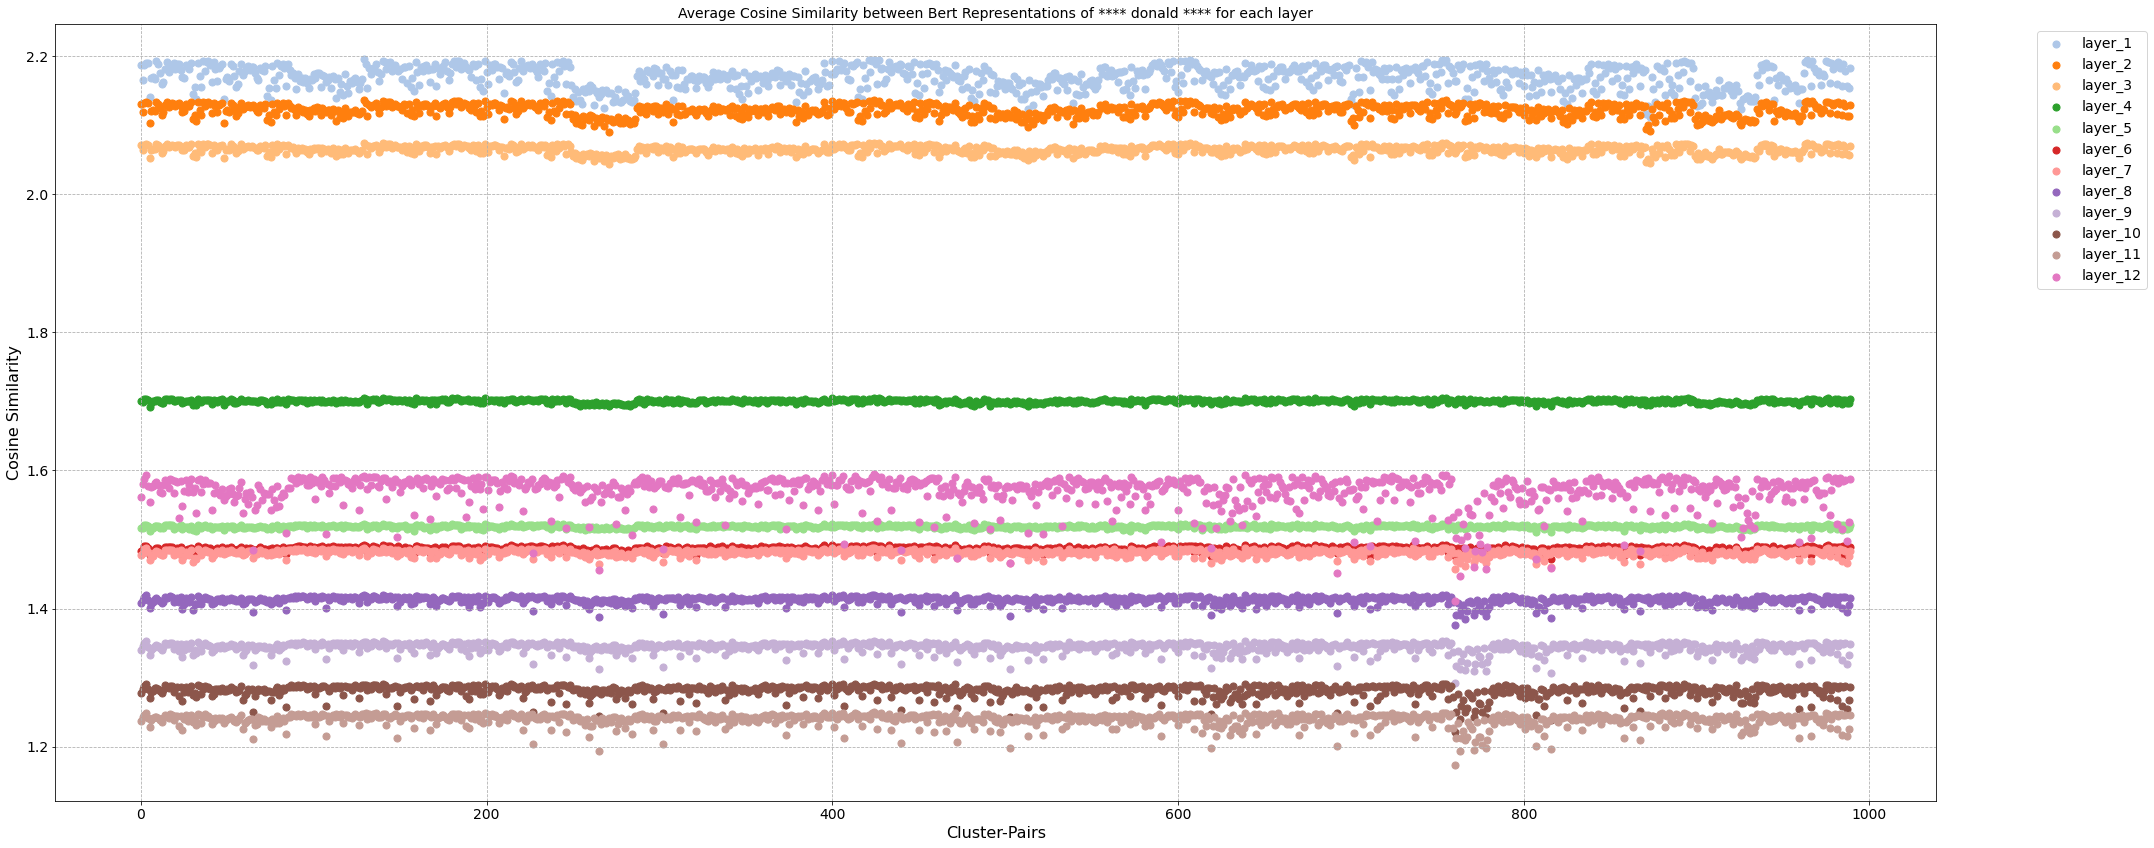

In [50]:
cosine_sim_map_scores = plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="donald",avg_rp_word_sim=avg_rp_score)

In [51]:
analyze_cluster_pairs(cps=cosine_sim_map_scores[12][:5],
                      relv_docs_cluster_map=relv_docs_cluster_map,
                      keyword="donald")


********* Analyzing Cluster Pair : (57, 59)************

Cluster 57 has 70 docs that contain donald keyword
Cluster 59 has 114 docs that contain donald keyword

Random Docs from Cluster : 57


Ilhan Omar condemns Trump for spreading 'lies that put my life at risk' | Ilhan Omar | The Guardian ilhan omar said ‘what twitter doing combat this misinformation’ photograph scott applewhiteap ilhan omar ilhan omar condemns trump for spreading ‘lies that put life risk’ democrat denounces president’ lies after retweeted post that falsely claimed omar was shown partying 911 anniversary congresswoman ilhan omar has accused donald trump putting her life risk after the president retweeted post that falsely claimed she partied the anniversary the september terrorist attacks trump retweeted post wednesday the conservative actor and comedian terrence williams asserting that film footage omar dancing was taken the 911 anniversary last week omar objected and said the video her dancing lizzo’ hit truth hu

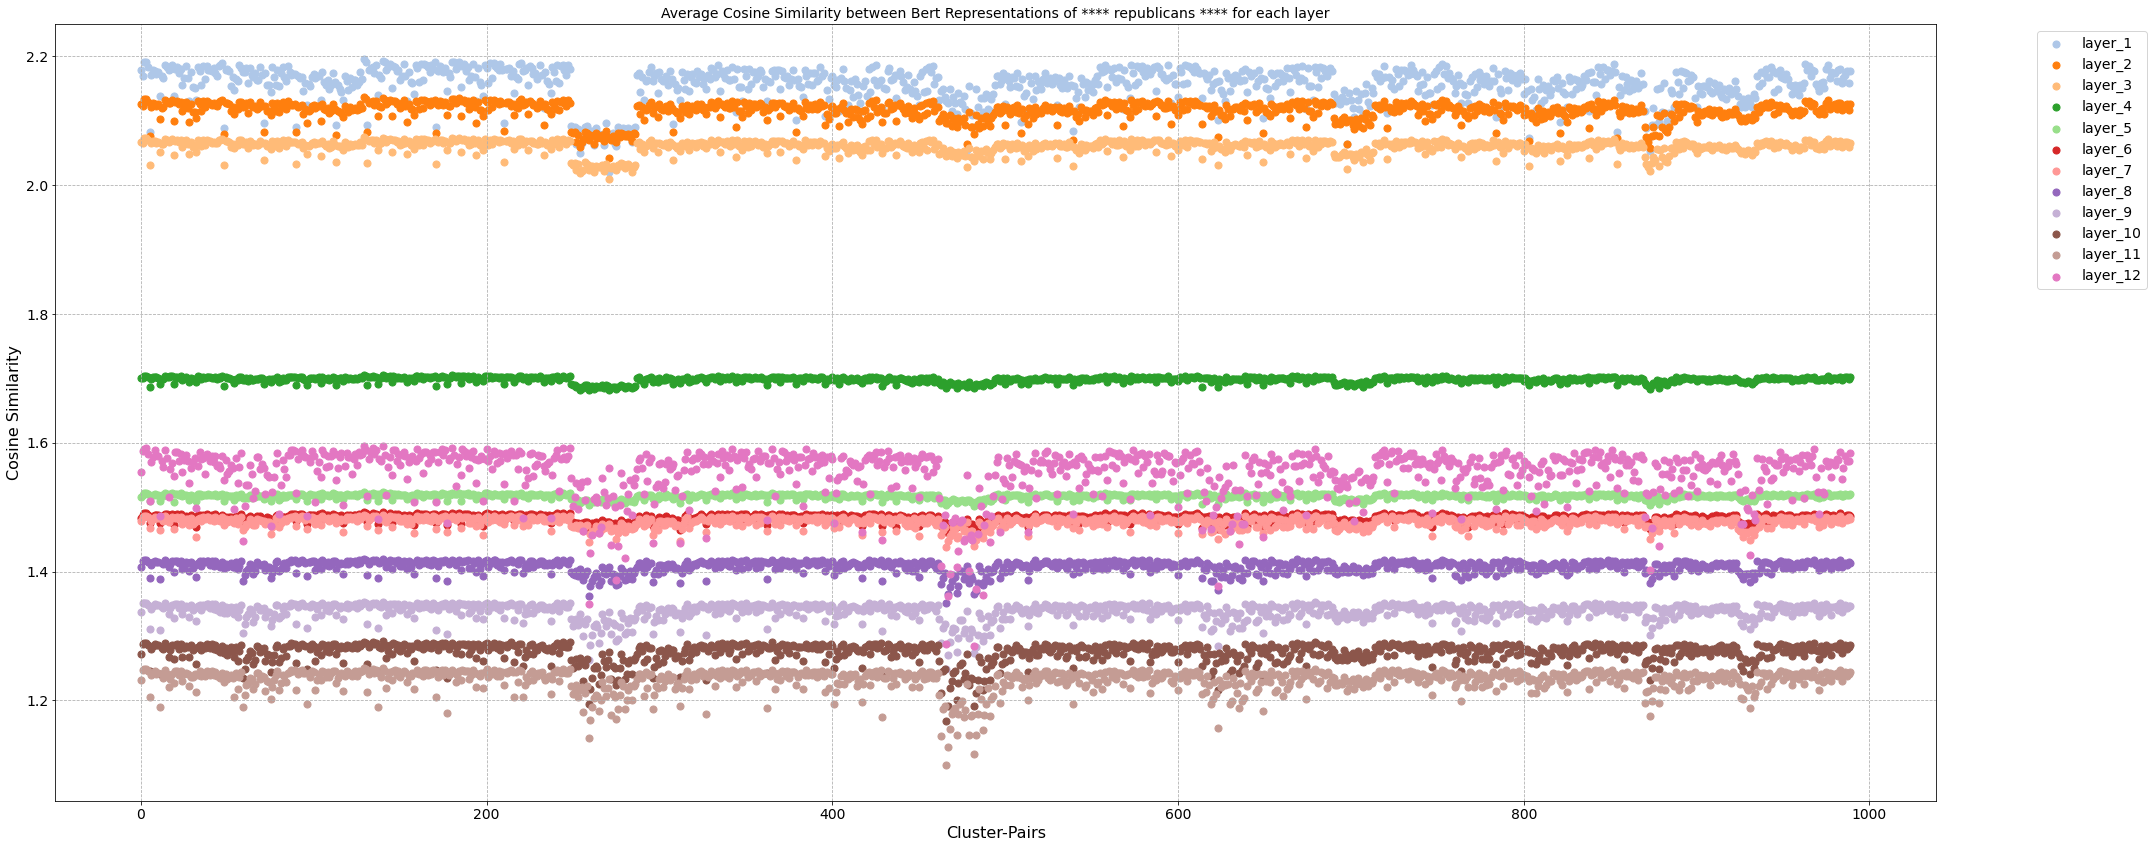

In [52]:
cosine_sim_map_scores = plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="republicans",avg_rp_word_sim=avg_rp_score)

In [53]:
analyze_cluster_pairs(cps=cosine_sim_map_scores[12][:5],
                      relv_docs_cluster_map=relv_docs_cluster_map,
                      keyword="republicans")


********* Analyzing Cluster Pair : (28, 77)************

Cluster 28 has 4 docs that contain republicans keyword
Cluster 77 has 6 docs that contain republicans keyword

Random Docs from Cluster : 28


Republicans and Democrats denounce Trump's shock Taliban talks revelation donald trump’ shock announcement that had canceled secret peace talks with the taliban this weekend has prompted criticism and confusion including from his own republican party the democratic presidential 2020 hopeful and minnesota senator amy klobuchar ridiculed the president sunday morning saying approaches foreign policy like “some kind gameshow” and the republican congressman adam kinzinger illinois gave trump dressing down “never should leaders terrorist organization that hasn’ renounced 911 and continues evil allowed our great country never full stop” tweeted shortly after trump’ announcement also via twitter saturday night trump revealed that separate meetings with the afghan president ashraf ghani and taliba

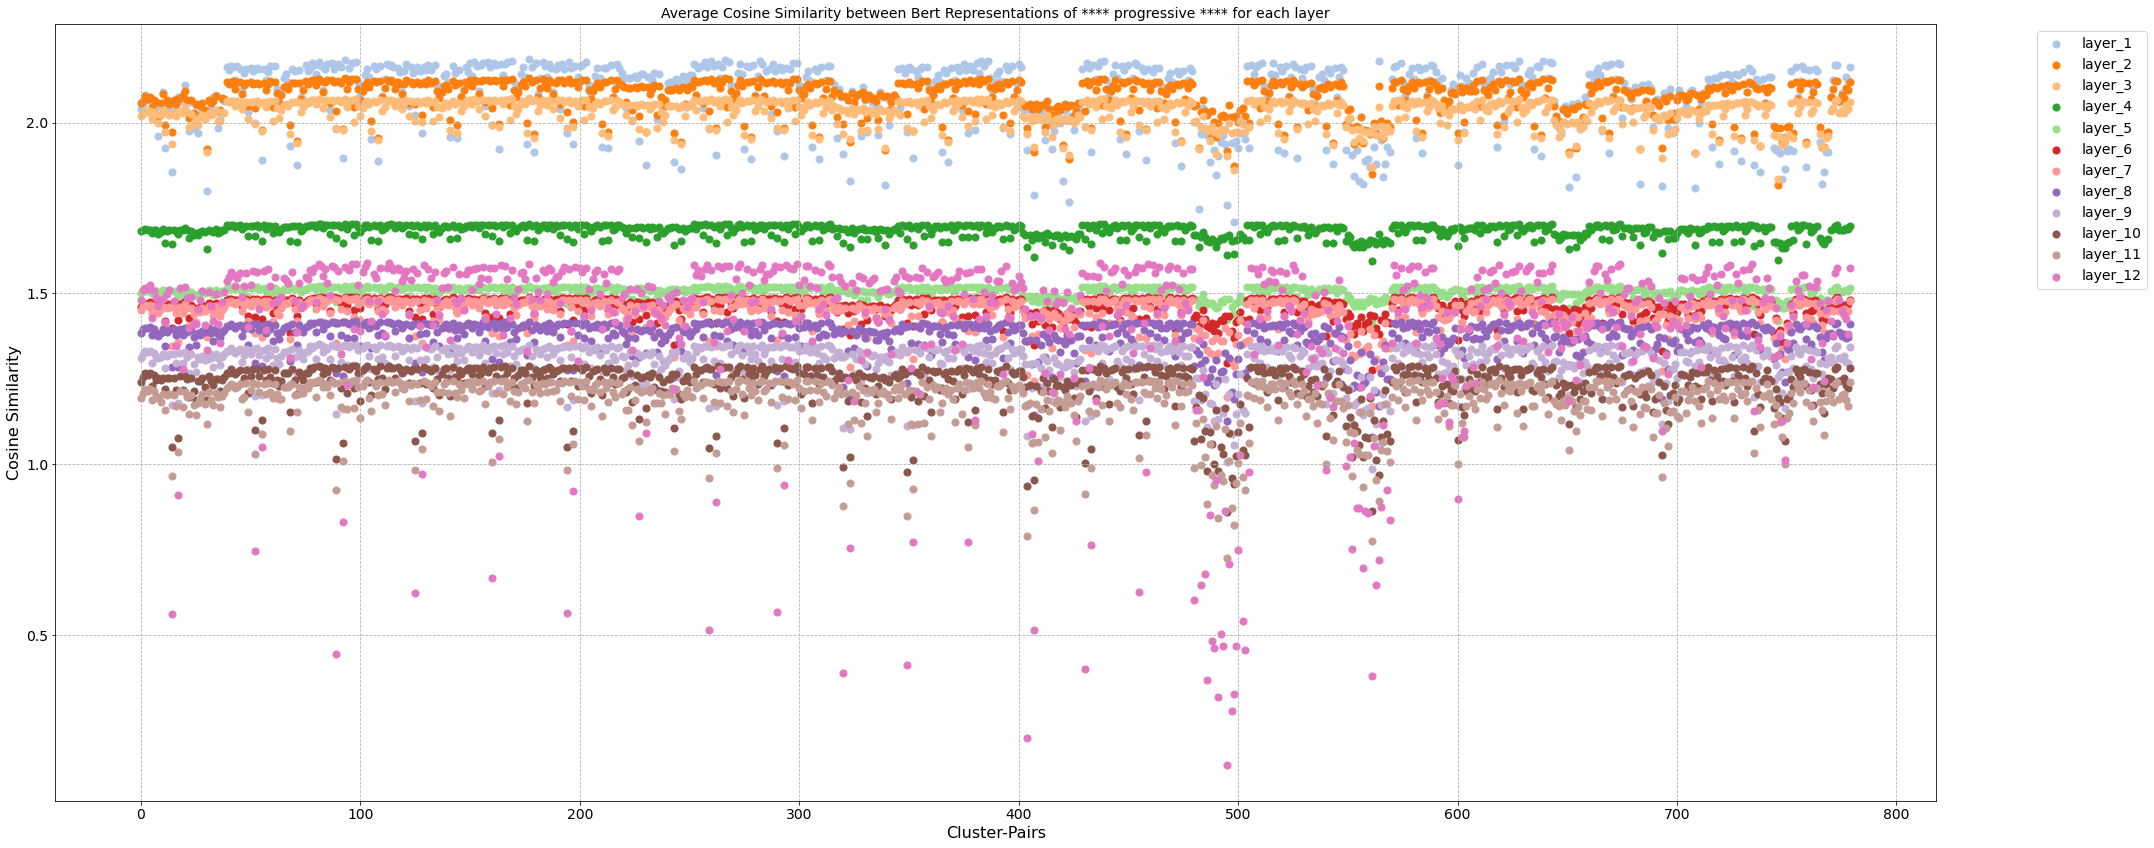

In [54]:
cosine_sim_map_scores = plot_keyword_cosine_sim_single_layer(layer_keyword_cluster_map,keyword="progressive", avg_rp_word_sim=avg_rp_score)

In [55]:
analyze_cluster_pairs(cps=cosine_sim_map_scores[12][:5],
                      relv_docs_cluster_map=relv_docs_cluster_map,
                      keyword="progressive")


********* Analyzing Cluster Pair : (36, 78)************

Cluster 36 has 1 docs that contain progressive keyword
Cluster 78 has 1 docs that contain progressive keyword

Random Docs from Cluster : 36


'He's desperate': Trump rants about impeachment 'con job' as McConnell admits he doesn't have the votes to block witnesses president donald trump fired off pair tweets tuesday night ranting about what called the “impeachment hoax” and “political con job” shortly after senate majority leader mitch mcconnell reportedly admitted closeddoor meeting with gop lawmakers that doesn’ have the votes stop witnesses from being called testify the ongoing trial “ matter how many witnesses you give the democrats matter how much information given like the quickly produced transcripts will never enough for them” trump tweeted “they will always scream unfair” separate tweet hours later trump asked why former national security adviser john bolton—the most prominent potential witness with firsthand knowledge

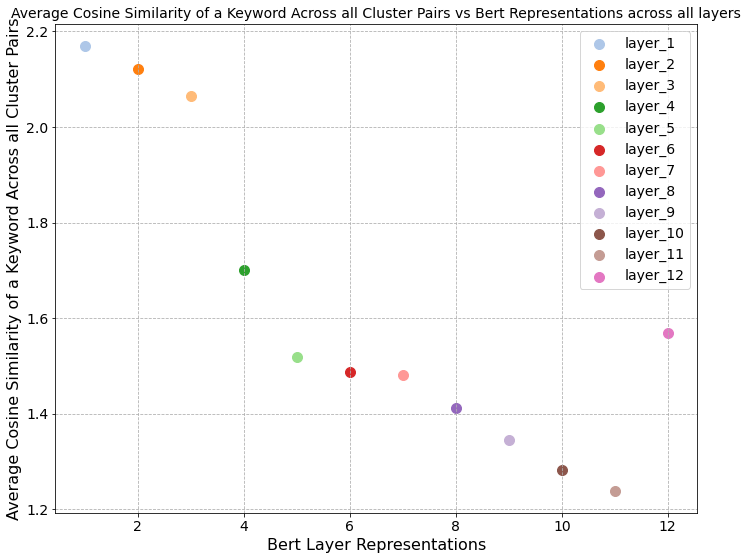

In [56]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="donald",avg_rp_word_sim=avg_rp_score)

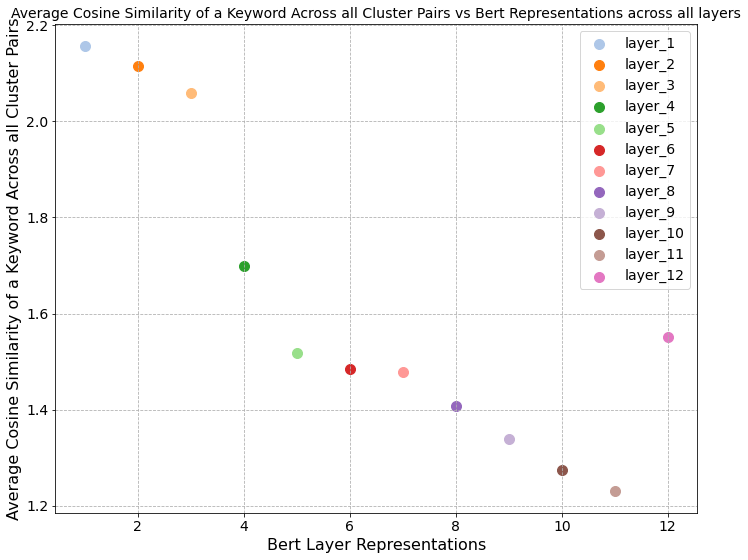

In [57]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="republicans",avg_rp_word_sim=avg_rp_score)

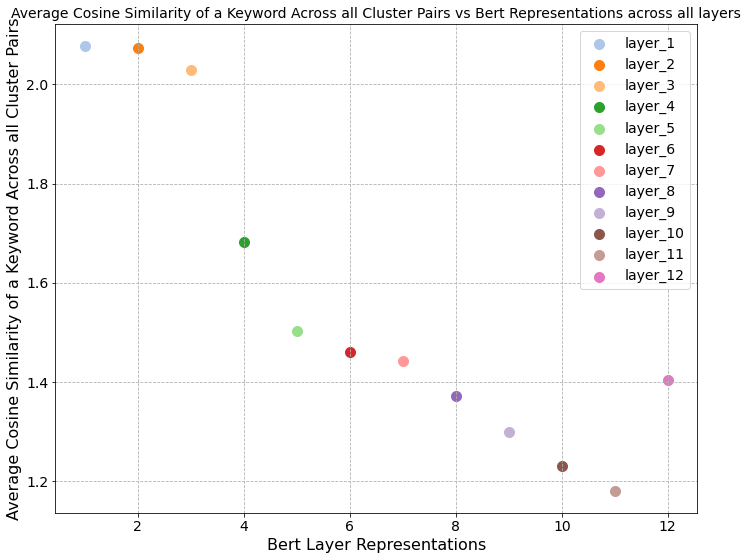

In [58]:
plot_keyword_avg_cos_sim_all_layers(layer_keyword_cluster_map,keyword="progressive", avg_rp_word_sim=avg_rp_score)

## Rep Var Analysisls

In [17]:
tokenizer = load_tokenizer()

In [11]:
tokenize_bert_single_token(token_batch=["socialist"],tokenizer=tokenizer,debug_flag=True)

socialist
['socialist', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


(tensor([[6102,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
        device='cuda:0'),
 [[6102, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
tokenize_bert_single_token(token_batch=["progressive"],tokenizer=tokenizer,debug_flag=True)

progressive
['progressive', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


(tensor([[6555,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
        device='cuda:0'),
 [[6555, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
type(tokenizer.vocab)

collections.OrderedDict

In [19]:
"socialist" in tokenizer.vocab

True

In [20]:
"progressive" in tokenizer.vocab

True